In [17]:
%%bash
pip install -U monai

In [18]:
import torch
import torchvision
from tqdm import tqdm
import numpy as np
from IPython.display import Image
from monai.transforms import (
    apply_transform,
    Randomizable,
    Compose,
    OneOf,
    EnsureChannelFirstDict,
    LoadImageDict,
    SpacingDict,
    OrientationDict,
    DivisiblePadDict,
    CropForegroundDict,
    ResizeDict,
    RandZoomDict,
    ZoomDict,
    RandRotateDict,
    HistogramNormalizeDict,
    ScaleIntensityDict,
    ScaleIntensityRangeDict,
    ToTensorDict,
    Transform
)

In [19]:
%%bash
mkdir -p vis

In [20]:
import os
import glob
from tqdm.auto import tqdm

In [21]:
def glob_files(folders: str = None, extension: str = "*.nii.gz"):
    assert folders is not None
    paths = [
        glob.glob(os.path.join(folder, extension), recursive=True)
        for folder in folders
    ]
    files = sorted([item for sublist in paths for item in sublist])
    print(len(files))
    print(files[:1])
    return files

ct_folders = [
    "../data/ChestXRLungSegmentation/NSCLC/processed/train/images",
]
ct_images = glob_files(
    ct_folders, 
    extension="*.nii.gz"
)

402
['../data/ChestXRLungSegmentation/NSCLC/processed/train/images/LUNG1-001_0000.nii.gz']


In [22]:
class UnSqueezeDim(Transform):
    """
    Squeeze unnecessary unitary dimensions
    """

    def __init__(self, dim=None):
        """
        Args:
            dim (int): dimension to be squeezed.
                Default: None (all dimensions of size 1 will be removed)
        """
        if dim is not None:
            assert isinstance(dim, int) and dim >= -1, 'invalid channel dimension.'
        self.dim = dim

    def __call__(self, img):
        """
        Args:
            data (dict): dictionary of numpy arrays with dim removed,
        """
        return np.expand_dims(img, self.dim)

class SqueezeDim(Transform):
    """
    Squeeze unnecessary unitary dimensions
    """

    def __init__(self, dim=None):
        """
        Args:
            dim (int): dimension to be squeezed.
                Default: None (all dimensions of size 1 will be removed)
        """
        if dim is not None:
            assert isinstance(dim, int) and dim >= -1, 'invalid channel dimension.'
        self.dim = dim

    def __call__(self, img):
        """
        Args:
            data (dict): dictionary of numpy arrays with dim removed,
        """
        return np.squeeze(img, self.dim)

In [23]:
# Define the transformation pipeline for "image2d"
val_transforms_asl = Compose(
    [
        LoadImageDict(keys=["image3d"]),
        EnsureChannelFirstDict(keys=["image3d"],),
        SpacingDict(
            keys=["image3d"],
            pixdim=(1.0, 1.0, 1.0),
            mode=["bilinear"],
            align_corners=True,
        ),
        OrientationDict(keys=("image3d"), axcodes="ASL"),
        ScaleIntensityRangeDict(
            keys=["image3d"],
            clip=True,
            a_min=-1024,
            a_max=+3071,
            b_min=0.0,
            b_max=1.0,
        ),
        CropForegroundDict(
            keys=["image3d"],
            source_key="image3d",
            select_fn=(lambda x: x > 0),
            margin=0,
        ),
        ZoomDict(keys=["image3d"], zoom=0.95, padding_mode="constant", mode=["area"]),
        ResizeDict(
            keys=["image3d"],
            spatial_size=256,
            size_mode="longest",
            mode=["trilinear"],
            align_corners=True,
        ),
        DivisiblePadDict(
            keys=["image3d"],
            k=256,
            mode="constant",
            constant_values=0,
        ),
        ToTensorDict(keys=["image3d"],),
    ]
)

# Run forward pass
device = torch.device('cuda:0')
B = 1

data = {}
data["image3d"] = ct_images[1]
image3d = val_transforms_asl(data)

image3d = image3d["image3d"].to(device)
image3d = image3d.unsqueeze(0)
print(image3d.shape)

/home/quantm/anaconda3/envs/kaolin/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


torch.Size([1, 1, 256, 256, 256])


In [24]:
from PIL import Image
import torch
import torch.nn.functional as F
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets as widgets
from termcolor import colored

import kaolin as kal
# from spc_formatting import describe_octree, color_by_level

features_grids = image3d
spc = kal.ops.spc.feature_grids_to_spc(features_grids)

In [25]:
len(spc)

3

In [26]:
def _normalized_grid(width, height, device='cuda'):
    """Returns grid[x,y] -> coordinates for a normalized window.
    
    Args:
        width, height (int): grid resolution
    """

    # These are normalized coordinates
    # i.e. equivalent to 2.0 * (fragCoord / iResolution.xy) - 1.0
    window_x = torch.linspace(-1, 1, steps=width, device=device) * (width / height)
    window_y = torch.linspace(1,- 1, steps=height, device=device)

    coord = torch.stack(torch.meshgrid(window_x, window_y)).permute(1,2,0)
    return coord


def look_at(camera_from, camera_to, width, height, mode='persp', fov=90.0, device='cuda'):
    """Vectorized look-at function, returns an array of ray origins and directions
    URL: https://www.scratchapixel.com/lessons/mathematics-physics-for-computer-graphics/lookat-function
    """

    camera_origin = torch.FloatTensor(camera_from).to(device)
    camera_view = F.normalize(torch.FloatTensor(camera_to).to(device) - camera_origin, dim=0)
    camera_right = F.normalize(torch.cross(camera_view, torch.FloatTensor([0,1,0]).to(device)), dim=0)
    camera_up = F.normalize(torch.cross(camera_right, camera_view), dim=0)

    coord = _normalized_grid(width, height, device=device)
    ray_origin = camera_right * coord[...,0,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_up * coord[...,1,np.newaxis] * np.tan(np.radians(fov/2)) + \
                 camera_origin + camera_view
    ray_origin = ray_origin.reshape(-1, 3)
    ray_offset = camera_view.unsqueeze(0).repeat(ray_origin.shape[0], 1)
    
    if mode == 'ortho': # Orthographic camera
        ray_dir = F.normalize(ray_offset, dim=-1)
    elif mode == 'persp': # Perspective camera
        ray_dir = F.normalize(ray_origin - camera_origin, dim=-1)
        ray_origin = camera_origin.repeat(ray_dir.shape[0], 1)
    else:
        raise ValueError('Invalid camera mode!')


    return ray_origin, ray_dir

In [27]:
# represent rays origin and direction vectors
ray_o, ray_d = look_at(
    camera_from=[-2, 2, -2],
    camera_to=[0, 0, 0],
    width=256,
    height=256,
    mode='persp',
    fov=20,
    device='cuda'
)

print(f'Total of {ray_o.shape[0]} rays generated.')

Total of 65536 rays generated.


In [28]:
octrees, lengths, features = spc[0], spc[1], spc[2]
print(octrees)
print(octrees.shape)
print(lengths)
print(lengths.shape)
print(features)
print(features.shape)

tensor([255, 255, 255,  ...,  95,  95,  95], device='cuda:0',
       dtype=torch.uint8)
torch.Size([1103126])
tensor([1103126], dtype=torch.int32)
torch.Size([1])
tensor([[1.2694e-04],
        [2.5167e-06],
        [9.1317e-04],
        ...,
        [3.1887e-04],
        [5.1064e-04],
        [5.1182e-04]], device='cuda:0')
torch.Size([7545969, 1])


In [29]:
max_level, pyramids, exsum = kal.ops.spc.scan_octrees(octrees, lengths)
print(max_level)
print(pyramids.shape)
print(exsum.shape)

8
torch.Size([1, 2, 10])
torch.Size([1103127])


In [30]:
point_hierarchies = kal.ops.spc.generate_points(octrees, pyramids, exsum)

In [44]:
nugs_ridx, nugs_pidx, depth = kal.render.spc.unbatched_raytrace(
    octrees, 
    point_hierarchies, 
    pyramids[0], exsum,
    ray_o, ray_d, max_level)

print(f'Total of {nugs_ridx.shape[0]} nuggets were traced.\n')
print(nugs_ridx)
print(nugs_pidx)
print(depth)
print(depth.shape)

Total of 22241743 nuggets were traced.

tensor([    0,     0,     0,  ..., 65535, 65535, 65535], device='cuda:0',
       dtype=torch.int32)
tensor([7358164, 7358168, 7358175,  ..., 2107432, 2106870, 2106873],
       device='cuda:0', dtype=torch.int32)
tensor([[3.2699],
        [3.2768],
        [3.2842],
        ...,
        [3.7444],
        [3.7506],
        [3.7572]], device='cuda:0')
torch.Size([22241743, 1])


torch.Size([65536, 3]) torch.Size([7545969, 1])


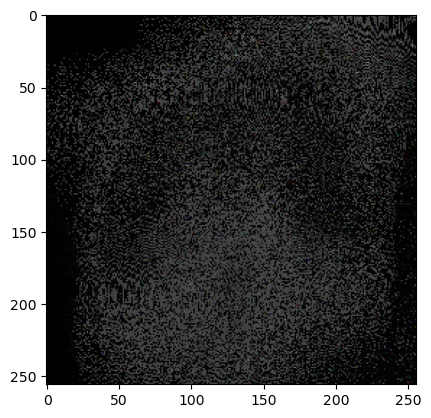

In [47]:
# 1. We initialize an empty canvas.
image = torch.ones_like(ray_o)

# 2. We'll query all first-hit nuggets to obtain their corresponding point-id (which cell they hit in the SPC).
ridx = nugs_ridx.long()
pidx = nugs_pidx.long() - pyramids.to(device)[:, 1, max_level]

# 3. We'll query the features auxilary structure to obtain the color.
# 4. We set each ray value as the corresponding nugget color.
# image[ridx] = features[pidx]
print(image.shape, features.shape)
image[ridx] = features[pidx]

image = image.reshape(256, 256, 3)
image = image.detach().cpu().numpy().transpose(1,0,2)
plt.imshow(image)